https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data

Tasks:

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Course/Data Science/How-to-Win-Kaggle-Competition/Final_Project')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
ls 'data'

item_categories.csv  sales_train_v2.csv     shops.csv
items.csv            sample_submission.csv  test.csv


## Import all datasets

In [0]:
item_categories = pd.read_csv('data/item_categories.csv')
sales_train = pd.read_csv('data/sales_train_v2.csv')
shops = pd.read_csv('data/shops.csv')
items = pd.read_csv('data/items.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
test_data = pd.read_csv('data/test.csv')

#### Item Categories Overview

In [0]:
item_categories.shape

(84, 2)

In [0]:
item_categories.iloc[[0,1,2,10,30,55,60,83], :]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
10,Игровые консоли - PS2,10
30,Игры PC - Стандартные издания,30
55,Музыка - CD локального производства,55
60,Музыка - Подарочные издания,60
83,Элементы питания,83


In [0]:
item_categories.item_category_name.nunique()

84

In [0]:
item_categories.item_category_id.agg(['min', 'max'])

min     0
max    83
Name: item_category_id, dtype: int64

Key points:
<br>

Item categories: supplemental information about the items categories.

- There are <b> 84 </b> unique categories in total. Some of them have similar stems
- <b> Category similarity </b> in some categories: e.g. Аксессуары - PS2 and Аксессуары - PS3 are both 'playstation'
- item category id ranges from <b> 0 to 83 </b>



#### Shops Overview

In [0]:
shops.shape

(60, 2)

In [0]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [0]:
shops.duplicated().any()

False

In [0]:
shops.isnull().any()

shop_name    False
shop_id      False
dtype: bool

In [0]:
shops.shop_id.agg(['min', 'max'])

min     0
max    59
Name: shop_id, dtype: int64

Key points:
<br>

- it has <b> 60 </b> shops.
- the shop id ranges from <b> 0 to 59 </br>

#### items overview

In [0]:
items.shape

(22170, 3)

In [0]:
items.sample(10)

,item_name,item_id,item_category_id
3864,"Hello, 1С (мастер-класс). Пример быстрой разра...",3864,54
14273,МАЙКЛ ДЖЕКСОН: ЛУННАЯ ПОХОДКА WB (регион),14273,40
17723,Приключения Тинтина: Тайна Единорога [Xbox 360],17723,23
16428,ОБИТЕЛЬ ЗЛА: ВОЗМЕЗДИЕ,16428,40
14791,МОСТЫ ОКРУГА МЭДИСОН (регион),14791,40
10733,ДАША-ПУТЕШЕСТВЕННИЦА. ВЫПУСК 5,10733,40
17921,РОЗЕНБАУМ АЛЕКСАНДР Grand Collection 1,17921,55
18285,СБ. ВИА ЗОЛОТЫЕ ХИТЫ Песни Давида Тухманова (...,18285,57
166,1С:Аудиокниги. Артур Конан Дойл. Истории о Шер...,166,45
13315,Комикс Супермен Земля-1 Книга 2,13315,47


In [9]:
itemG = items.groupby('item_category_id').item_name.size().to_frame('Number_of_items').sort_values(by = 'Number_of_items', ascending = False)
itemG.head(5)

,Number_of_items
item_category_id,
40,5035
55,2365
37,1780
31,1125
58,790


In [0]:
items.item_name.nunique()

22170

In [10]:
itemG.Number_of_items.quantile([0., 0.25, 0.5, 0.75, 1.])

0.00       1.0
0.25       8.0
0.50      43.5
0.75     291.0
1.00    5035.0
Name: Number_of_items, dtype: float64

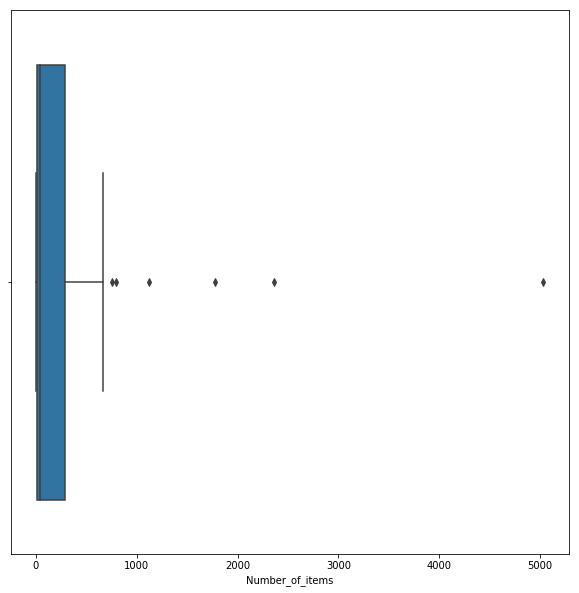

In [12]:
fig = plt.figure(figsize=(10, 10))
sns.boxplot(itemG.Number_of_items, orient = 'h');

In [0]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

rs = np.random.RandomState(8)

_ = rs.choice(itemG.Number_of_items, len(itemG.Number_of_items), replace=False)
sns.barplot(x=itemG.index, y=_, palette="deep");

In [0]:
itemG = itemG.join(item_categories.set_index('item_category_id'), on='item_category_id')
itemG = itemG.loc[:, ['item_category_name', 'Number_of_items']]
itemG.head(10)

,item_category_name,Number_of_items
item_category_id,,
40,Кино - DVD,5035
55,Музыка - CD локального производства,2365
37,Кино - Blu-Ray,1780
31,Игры PC - Цифра,1125
58,Музыка - Винил,790
30,Игры PC - Стандартные издания,756
72,Подарки - Фигурки,666
19,Игры - PS3,628
61,Подарки - Атрибутика,598


key point:
<br>

- it has <b> 22170 </b> unique items (item names)
- group by the categories, number of items in each categories are skewed to the right, where the are 6 categories are considered outliers with lots of items:
  * 40: Кино - DVD
  * 55: Музыка - CD локального производства	
  * 37: Кино - Blu-Ray
  * 31: Игры PC - Цифра	
  * 58: Музыка - Винил
  * 30: Игры PC - Стандартные издания

#### sales overview

In [13]:
sales_train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


In [14]:
sales_train.shape

(2935849, 6)

In [15]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [17]:
date_ = sales_train.date.str.split('.', expand = True)
date_[:10]

,0,1,2
0,02,01,2013
1,03,01,2013
2,05,01,2013
3,06,01,2013
4,15,01,2013
5,10,01,2013
6,02,01,2013
7,04,01,2013
8,11,01,2013
9,03,01,2013


In [18]:
sales_train['day'] = date_[0]
sales_train['month'] = date_[1]
sales_train['year'] = date_[2]
sales_train.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,02,01,2013
1,03.01.2013,0,25,2552,899.00,1.0,03,01,2013
2,05.01.2013,0,25,2552,899.00,-1.0,05,01,2013
3,06.01.2013,0,25,2554,1709.05,1.0,06,01,2013
4,15.01.2013,0,25,2555,1099.00,1.0,15,01,2013
5,10.01.2013,0,25,2564,349.00,1.0,10,01,2013
6,02.01.2013,0,25,2565,549.00,1.0,02,01,2013
7,04.01.2013,0,25,2572,239.00,1.0,04,01,2013
8,11.01.2013,0,25,2572,299.00,1.0,11,01,2013
9,03.01.2013,0,25,2573,299.00,3.0,03,01,2013


In [23]:
cols = sales_train.columns.to_list()
cols

['date',
 'date_block_num',
 'shop_id',
 'item_id',
 'item_price',
 'item_cnt_day',
 'day',
 'month',
 'year']

In [25]:
cols = cols[:1] + cols[-3:] + cols[1:-3]
cols

['date',
 'day',
 'month',
 'year',
 'date_block_num',
 'shop_id',
 'item_id',
 'item_price',
 'item_cnt_day']

In [26]:
sales_train = sales_train.loc[:, cols]
sales_train.head(3)

,date,day,month,year,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,02,01,2013,0,59,22154,999.0,1.0
1,03.01.2013,03,01,2013,0,25,2552,899.0,1.0
2,05.01.2013,05,01,2013,0,25,2552,899.0,-1.0


In [27]:
sales_train.groupby('year').size()

year
2013    1267562
2014    1055861
2015     612426
dtype: int64

In [32]:
sales_record_by_time = sales_train.groupby(['year', 'month']).size().to_frame('Total_records')
sales_record_by_time.head(10)

Total_records
year month               
2013 01            115690
     02            108613
     03            121347
     04             94109
     05             91759
     06            100403
     07            100548
     08            104772
     09             96137
     10             94202

In [55]:
sales_record_by_time[12:24]

Total_records
year month               
2014 01             99349
     02             89830
     03             92733
     04             77906
     05             78529
     06             82408
     07             78760
     08             86614
     09             73157
     10             79361
     11             86428
     12            130786

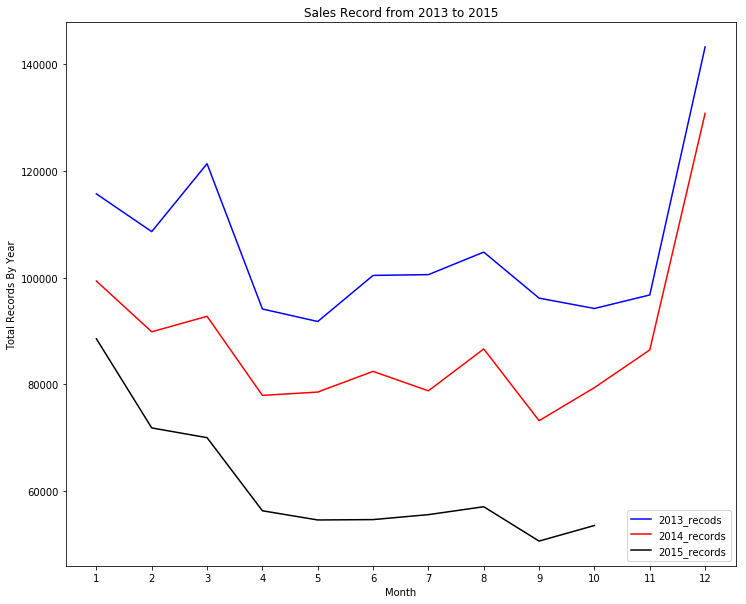

In [54]:
x = list(range(1, 13))
plt.figure(figsize = (12, 10))
plt.plot(x, sales_record_by_time[:12], label='2013_recods', c='b')
plt.plot(x, sales_record_by_time[12:24], label='2014_records', c='r')
plt.plot(x[:10], sales_record_by_time[24:], label='2015_records', c='k')
plt.xticks(range(1, 13), list(range(1, 13)))
plt.legend(loc='lower right')

plt.xlabel('Month', fontsize=10)
plt.ylabel('Total Records By Year', fontsize=10)
plt.title('Sales Record from 2013 to 2015', fontsize=12)


plt.show()


Key points:
<br>

From 3 years:
- three peaks: Mar, August, Dec
- two valleys: Apr, Sep

<br>

From different years:
- decrease year by year, month by month 

In [60]:
sales_train['revenue'] = sales_train.item_price * sales_train.item_cnt_day
sales_by_years_and_revenue = sales_train.groupby(['year', 'month'])['revenue'].sum().to_frame('Total_revenue')
sales_by_years_and_revenue = np.round(sales_by_years_and_revenue/1000000, 2)
sales_by_years_and_revenue.columns = ['Total_Rev(M)']
sales_by_years_and_revenue

Total_Rev(M)
year month              
2013 01            91.95
     02            90.67
     03           104.93
     04            69.15
     05            65.07
     06            79.55
     07            69.35
     08            74.30
     09           119.08
     10           107.24
     11           138.67
     12           207.57
2014 01            98.23
     02           107.43
     03           109.12
     04            80.65
     05            91.28
     06            82.67
     07            76.49
     08            89.60
     09           114.72
     10           112.53
     11           152.04
     12           232.03
2015 01           118.93
     02            86.59
     03            86.48
     04            90.25
     05            88.58
     06            65.40
     07            59.41
     08            61.75
     09            92.91
     10            84.34

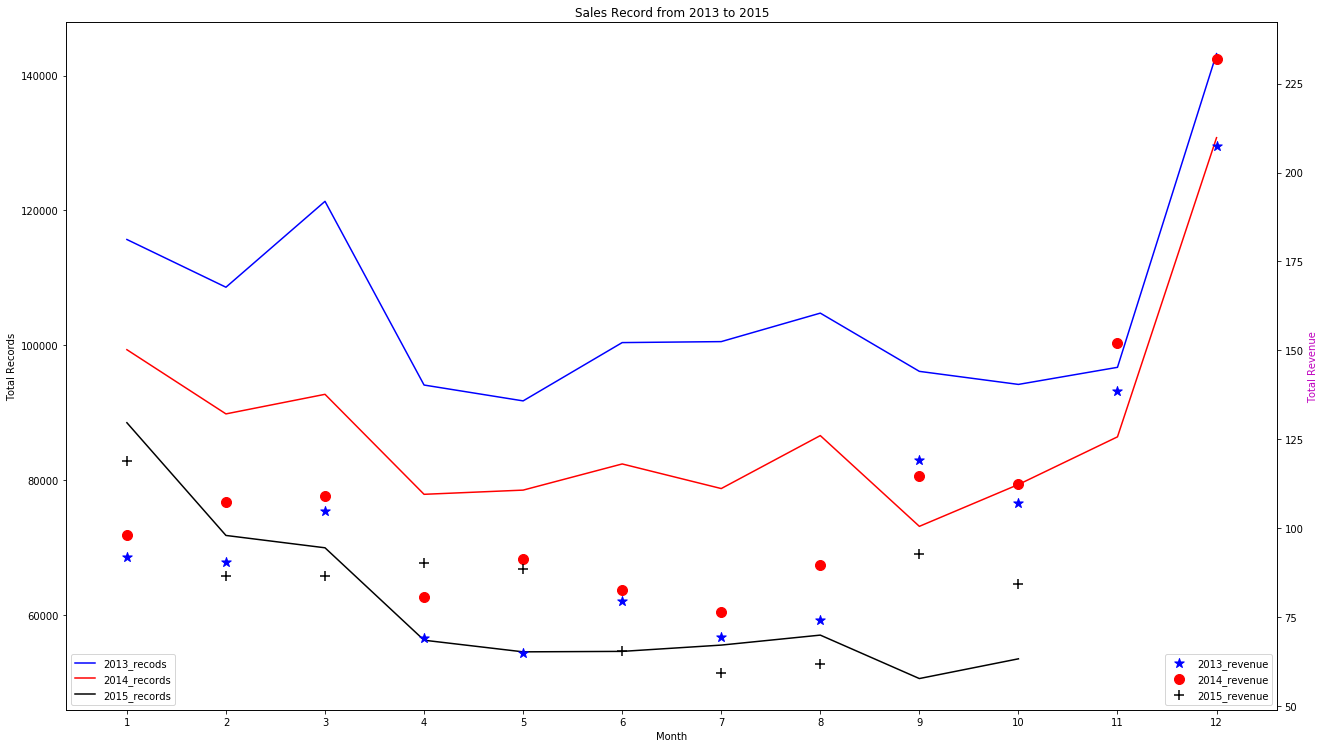

In [81]:
x = list(range(1, 13))

fig, ax1 = plt.subplots()

ax1.labelsize = 'large'
fig.set_size_inches(18.5, 10.5)
ax1.plot(x, sales_record_by_time[:12], label='2013_recods', c='b')
ax1.plot(x, sales_record_by_time[12:24], label='2014_records', c='r')
ax1.plot(x[:10], sales_record_by_time[24:], label='2015_records', c='k')
plt.xticks(range(1, 13), list(range(1, 13)))
ax1.legend(loc='lower left')

ax1.set_xlabel('Month', fontsize=10)
ax1.set_ylabel('Total Records', fontsize=10, color='k')
plt.title('Sales Record from 2013 to 2015', fontsize=12)

ax2 = ax1.twinx()
ax2.labelsize = 'large'
ax2.set_ylabel('Total Revenue', fontsize=10, color='m')
ax2.scatter(x, sales_by_years_and_revenue[:12], c='b', marker='*', s=100, label='2013_revenue')
ax2.scatter(x, sales_by_years_and_revenue[12:24], c='r', marker='o', s=100, label='2014_revenue')
ax2.scatter(x[:10], sales_by_years_and_revenue[24:], c='k', marker='+', s=100, label='2015_revenue')
ax2.legend(loc='lower right')
fig.tight_layout()
plt.show()